In [1]:
import pandas as pd
from fractions import Fraction
import cufflinks as cf
cf.go_offline()
cf.set_config_file(theme='white')

### Helpers

In [2]:
PITCH_NAMES = {0: 'F', 1: 'C', 2: 'G', 3: 'D', 4: 'A', 5: 'E', 6: 'B'}

def tpc2name(tpc):
    """Return name of a tonal pitch class where
       0 = C, -1 = F, -2 = Bb, 1 = G etc.
    """
    try:
        tpc = int(tpc) + 1 # to make the lowest name F = 0 instead of -1
    except:
        raise ValueError(f"'{tpc}' is not a TPC.")

    acc = abs(tpc // 7) * 'b' if tpc < 0 else tpc // 7 * '#'
    return PITCH_NAMES[tpc % 7] + acc

# Loading the note lists for ~700 compositions

* id: which piece
* mn: measure number (=bar number)
* onset: distance from the measure's beginning (expressed as fraction of a whole note, so that 1/4 = quarter note)
* duration: duration (expressed as fraction of a whole note, so that 1/4 = quarter note)
* tpc: tonal pitch class, expressed on the line of fifth with (any) C = 0 (see below)
* midi: pitch expressed as piano key with 60 = C4
* keysig: Key signature of the score, 3 = 3 sharps; -3 = 3 flats
* timesig: Time signature of the score (question: why isn't this column conserved as a string, instead of parsing the fraction?)

### TPC (extends in both directions)

|tpc|pitch|accidental|
|---|-----|----------|
|-9|B|$\flat\flat$|
|-8|F|$\flat$|
|-7|C|$\flat$|
|-6|G|$\flat$|
|-5|D|$\flat$|
|-4|A|$\flat$|
|-3|E|$\flat$|
|-2|B|$\flat$|
|-1|F||
|0|C||
|1|G||
|2|D||
|3|A||
|4|E||
|5|B||
|6|F|$\sharp$|
|7|C|$\sharp$|
|8|G|$\sharp$|
|9|D|$\sharp$|
|10|A|$\sharp$|
|11|E|$\sharp$|
|12|B|$\sharp$|
|13|F|$\sharp\sharp$|


In [2]:
dtypes = dict({col: int for col in ['id', 'mn', 'tpc', 'midi', 'keysig']}, timesig=str)
converters = {col: Fraction for col in ['onset', 'duration']}
notes = pd.read_csv('note_list.tsv', sep='\t', dtype=dtypes, converters=converters)
print(notes.shape)
notes.head(5)

(1079574, 8)


id  mn onset duration  tpc  midi  keysig timesig
0   0   1     0     1/16    3    45       3    12/8
1   0   1  1/16     1/16    7    49       3    12/8
2   0   1   1/8     1/16    4    52       3    12/8
3   0   1  3/16     1/16    3    57       3    12/8
4   0   1   1/4     1/16    8    56       3    12/8

# Counting notes 

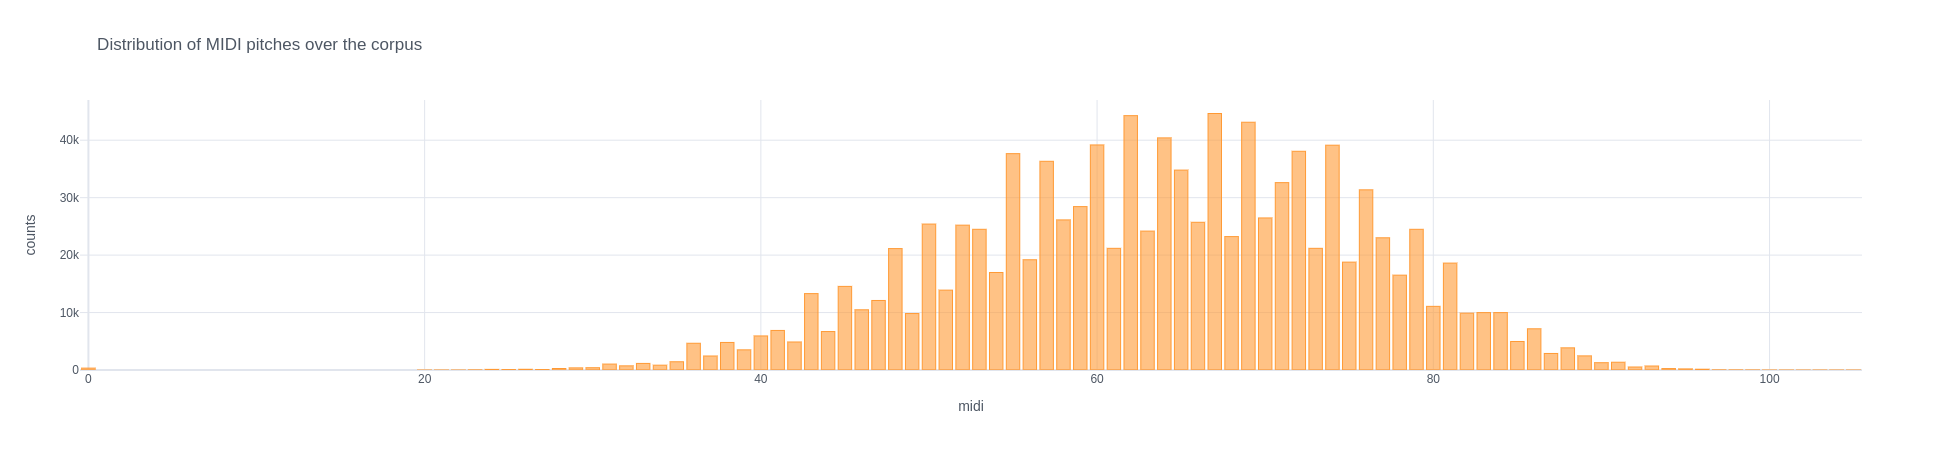

In [4]:
notes.midi.value_counts().iplot('bar', title='Distribution of MIDI pitches over the corpus', xTitle='midi', yTitle='counts')

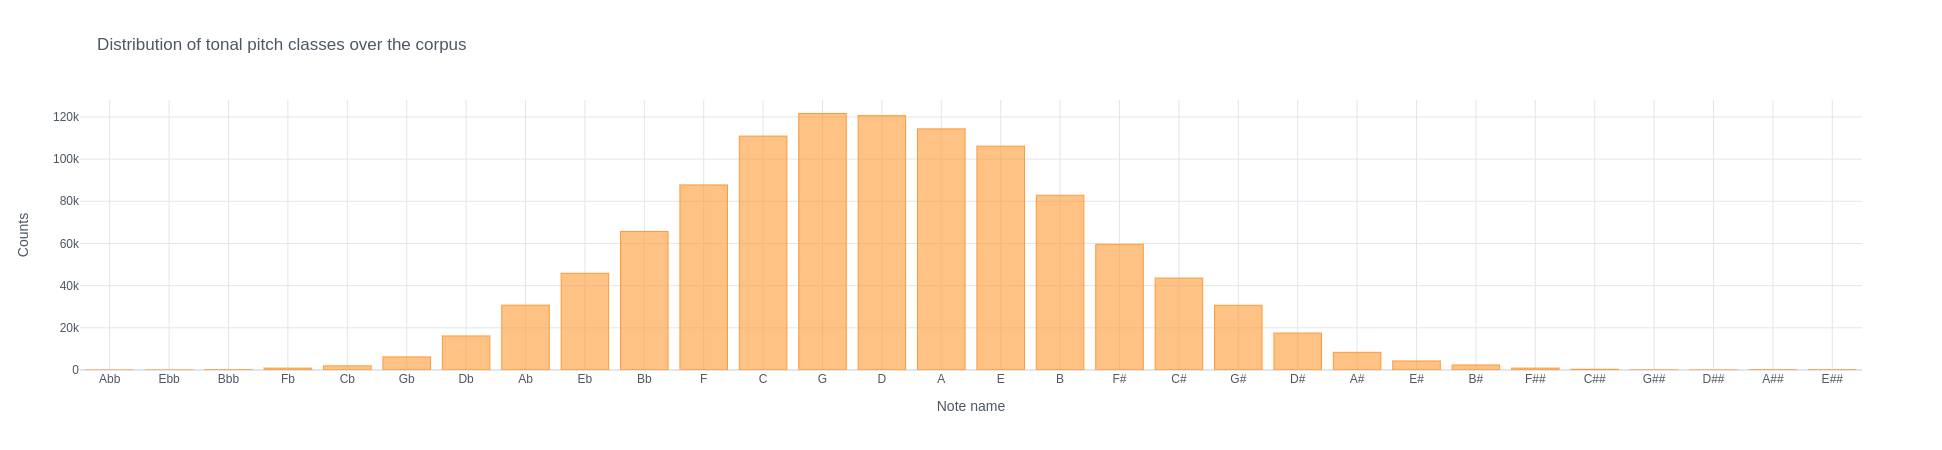

In [5]:
notes.tpc.value_counts()\
        .sort_index()\
        .rename(tpc2name)\
        .iplot('bar', title='Distribution of tonal pitch classes over the corpus', xTitle='Note name', yTitle='Counts')

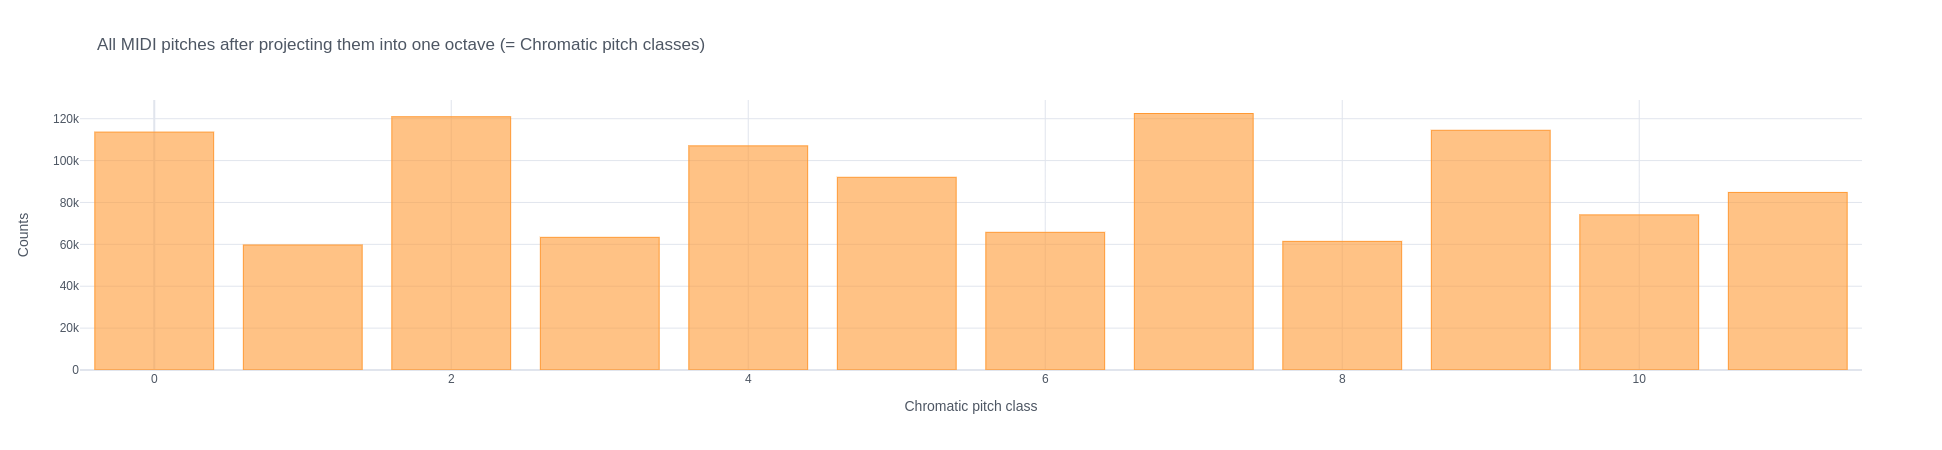

In [6]:
notes['pc'] = notes.midi.map(lambda x: x%12)
notes.pc.value_counts().iplot('bar', title='All MIDI pitches after projecting them into one octave (= Chromatic pitch classes)', xTitle='Chromatic pitch class', yTitle='Counts')

As noted in class, this distribution shows how often every key of the piano is pressed if you play all notes of all pieces in the middle octave. The plot reveals that

* the white keys [0, 2, 4, 5, 7, 9, 11] will be pressed more frequently than the black keys [1, 3, 6, 8, 10],
* Bb/A# is the most frequent black key,
* B/Cb  is the least frequent white key.

### How many notes in one piece?

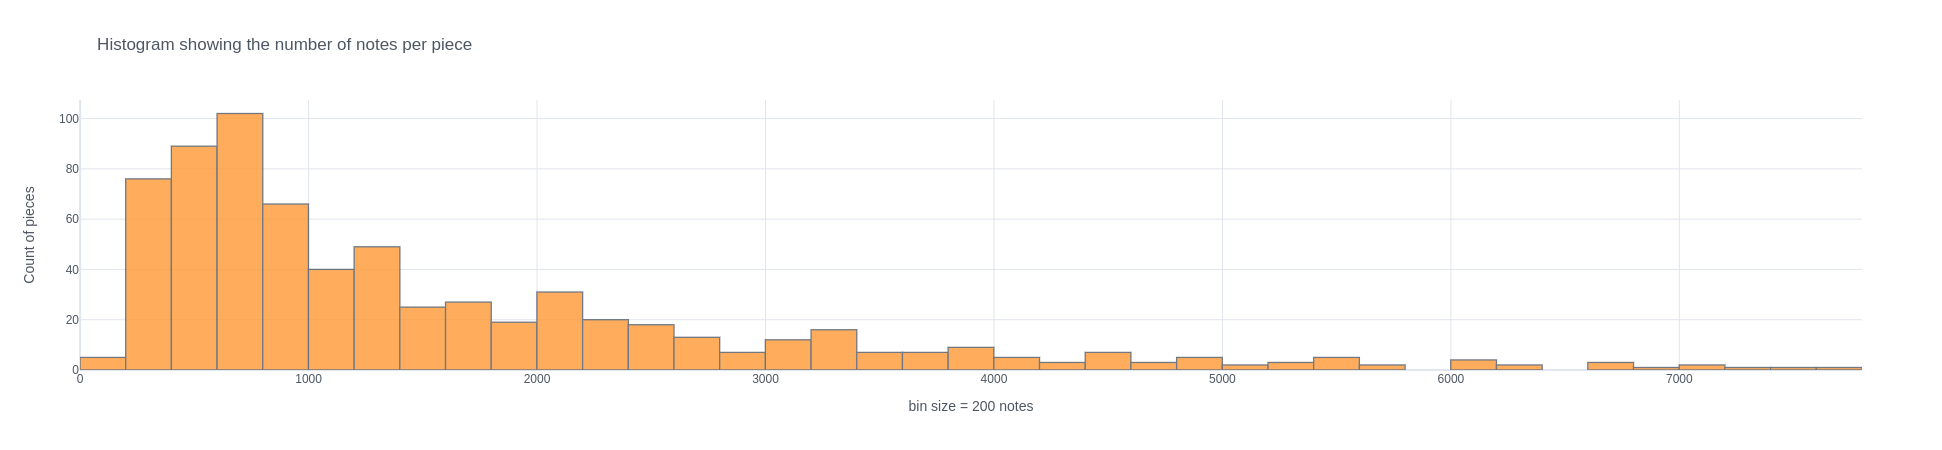

In [7]:
notes.groupby('id').size().iplot('hist', bins=50, title='Histogram showing the number of notes per piece', xTitle='bin size = 200 notes', yTitle='Count of pieces')

### Tone counts per piece

In [86]:
norm = lambda df: df.div(df.sum(axis=1), axis=0)

In [9]:
pc_counts = notes.groupby('id').pc.value_counts().unstack()
pc_counts = norm(pc_counts)
pc_counts.head(10)

pc        0         1         2         3         4         5         6   \
id                                                                         
0   0.002307  0.133795  0.116494  0.023068  0.154556  0.010381  0.131488   
1   0.010288  0.128601  0.069959  0.047325  0.155350  0.011317  0.130658   
2        NaN  0.126904  0.076142  0.035533  0.159898  0.012690  0.129442   
3        NaN  0.145585  0.095465  0.014320  0.159905       NaN  0.116945   
4        NaN  0.136000  0.114000  0.020000  0.166000       NaN  0.120000   
5        NaN  0.126984  0.099206  0.015873  0.170635       NaN  0.113095   
6   0.017582  0.116484  0.140659  0.010989  0.178022  0.015385  0.109890   
7        NaN  0.162021  0.104530  0.020906  0.163763  0.001742  0.090592   
8   0.131519  0.009070  0.124717  0.006803  0.170068  0.095238  0.031746   
9   0.002494  0.110973  0.108479  0.029925  0.172070       NaN  0.132170   

pc        7         8         9         10        11  
id                                                    
0   0.023068  0.103806  0.146482  0.014994  0.139562  
1   0.017490  0.116255  0.144033  0.029835  0.138889  
2        NaN  0.126904  0.170051  0.005076  0.157360  
3   0.045346  0.066826  0.150358  0.023866  0.181384  
4   0.042000  0.076000  0.138000  0.024000  0.164000  
5   0.039683  0.071429  0.164683  0.017857  0.180556  
6   0.048352  0.061538  0.142857  0.013187  0.145055  
7   0.013937  0.087108  0.172474  0.005226  0.177700  
8   0.072562  0.047619  0.156463  0.004535  0.149660  
9   0.028678  0.103491  0.154613  0.006234  0.150873

Cufflinks uses the index for the x-axis and every column as one trace. That's why the DataFrame needs to be transposed for this plot:

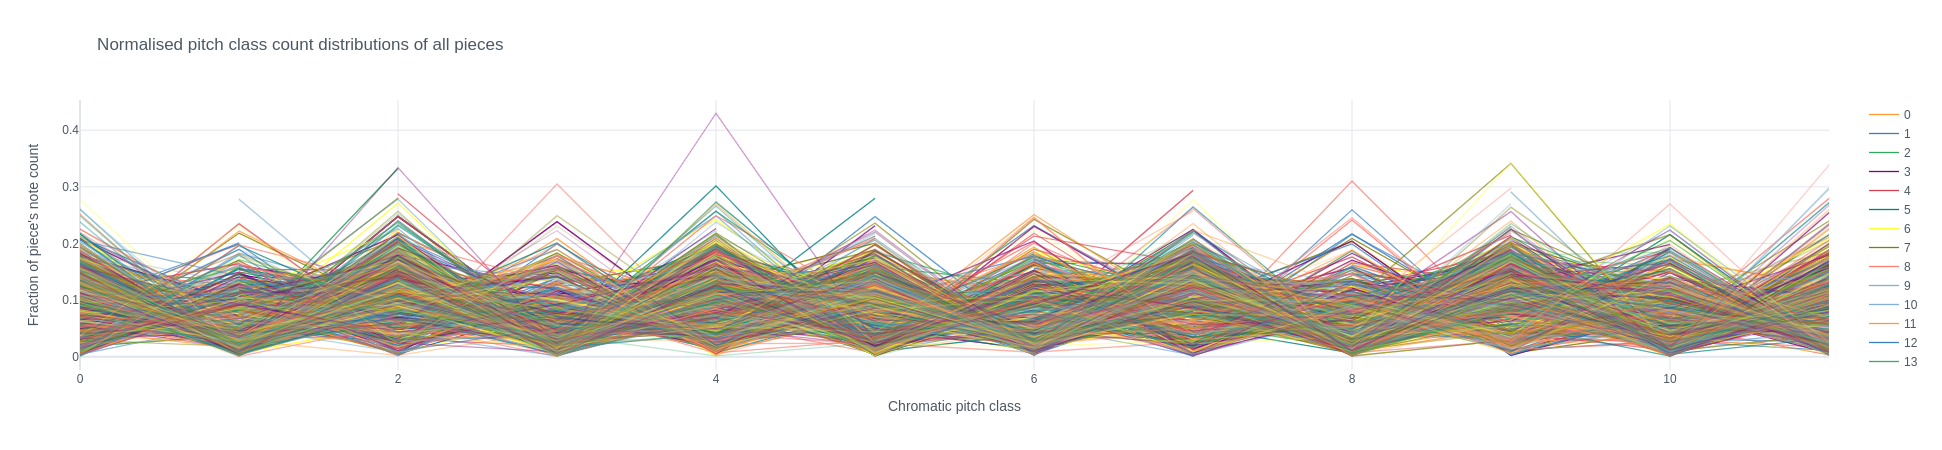

In [10]:
pc_counts.T.iplot(title='Normalised pitch class count distributions of all pieces', xTitle='Chromatic pitch class', yTitle="Fraction of piece's note count")

### Tone durations per piece

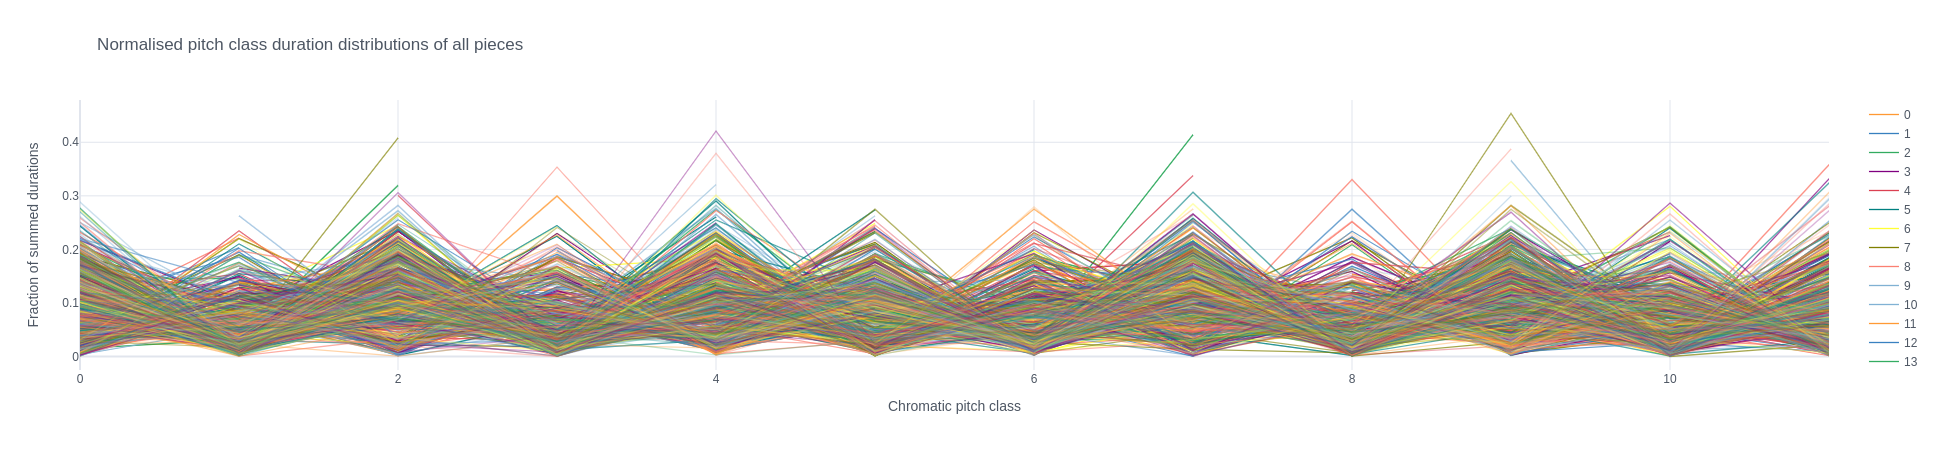

In [11]:
pc_durations = notes.groupby(['id', 'pc']).duration.sum().unstack()
pc_durations = norm(pc_durations).astype(float)
pc_durations.T.iplot(title='Normalised pitch class duration distributions of all pieces', xTitle='Chromatic pitch class', yTitle='Fraction of summed durations')

# Tonal Hierarchy

* As you see, different pieces favour different sets of pitches.
* Use your knowledge about tonal hierarchies to infer from the data for every piece its global key, that is
    * its root
    * whether it is in minor or major.
* Use the distributions of pitch durations rather than those of pitch counts.
* Small caveat: You can expect the root and the fifth above it to be the two most frequent pitches, but in many cases, the fifth is more frequent than the root. Why do you think is that and how can we solve the problem?
* Solve the problem with the MIDI information (i.e., pitch classes) and compare it to the ground truth. Note that from the chromatic pitch class that you name as root, you can only guess the correct tonal pitch class.

## Additional task for digging deeper

How does the task change if we use tonal pitch classes for finding the key?

### Hint 1

One way to go at it would consist in transposing the tone distributions to set the root to 0. You can apply this function to rotate a row by n:

In [ ]:
import numpy as np
rotate_series = lambda row, n: pd.Series(np.roll(row, n))

### Hint 2
This is what the mean of the ground truth for major and minor looks like:

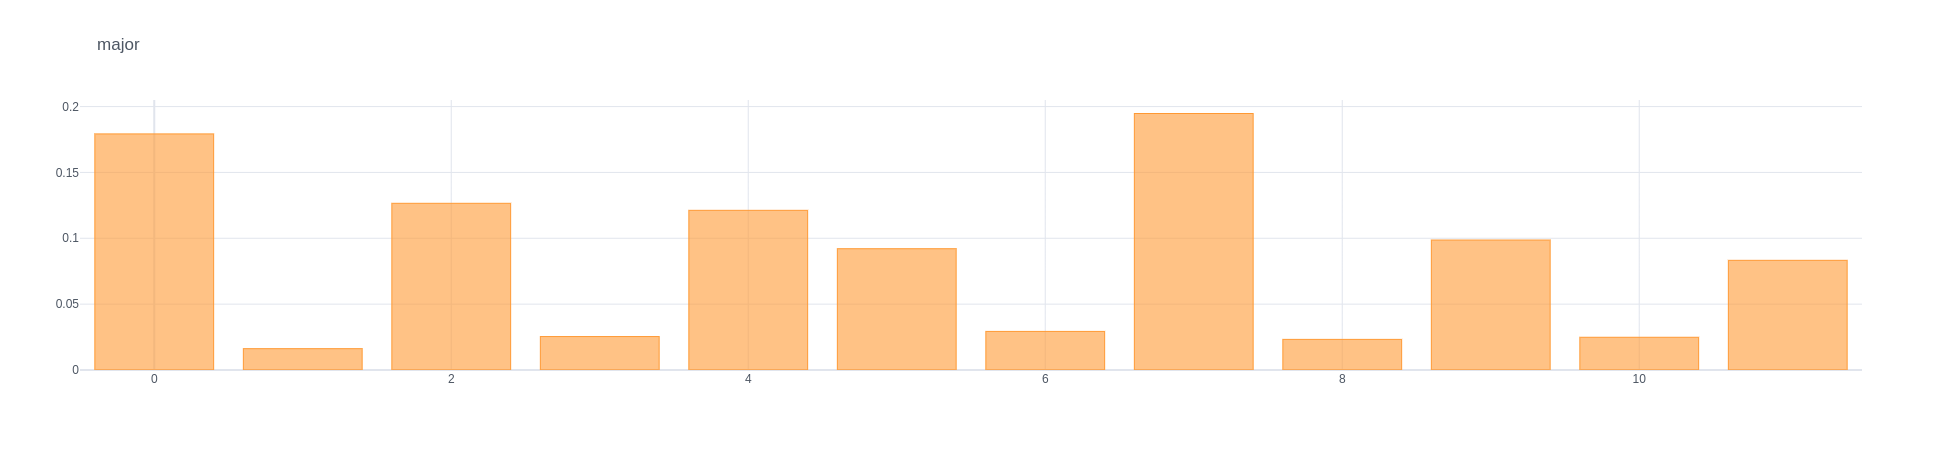

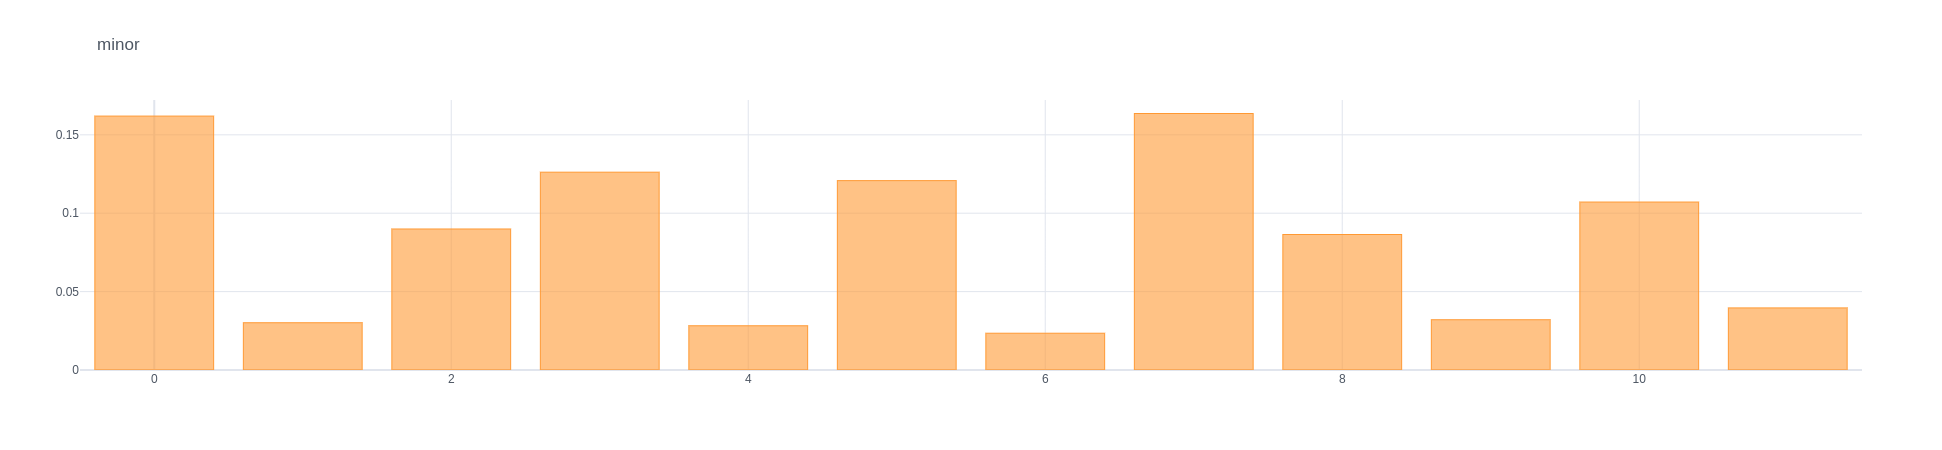

In [146]:
major_mean_pc_duration = {
 0: 0.1792334741300649,
 1: 0.016194246522623856,
 2: 0.12655280537743901,
 3: 0.025386044326330903,
 4: 0.12121976418935039,
 5: 0.09207725352852898,
 6: 0.02930039349131656,
 7: 0.19473155624848157,
 8: 0.02324467767869272,
 9: 0.09867587704734578,
 10: 0.024848467922041463,
 11: 0.08326001666922679}

minor_mean_pc_duration = {
 0: 0.16195224046022005,
 1: 0.03014516030424735,
 2: 0.08993909167778845,
 3: 0.1261668911358516,
 4: 0.02821709371392731,
 5: 0.12078263380972043,
 6: 0.023455154424039615,
 7: 0.16359499887584905,
 8: 0.08642460807252482,
 9: 0.032053164535953325,
 10: 0.10712390344531529,
 11: 0.039598903486405754}
pd.Series(major_mean_pc_duration).iplot('bar', title='major')
pd.Series(minor_mean_pc_duration).iplot('bar', title='minor')

### Loading the ground truth

In [18]:
keys = pd.read_csv('keys.tsv', sep='\t', index_col=0)
keys['mode'] = keys.globalkey.str.isupper().replace({True: 'major', False:'minor'})
keys.head(11)

globalkey   mode
id                 
0          A  major
1          A  major
2          A  major
3          A  major
4          A  major
5          A  major
6          A  major
7          A  major
8          a  minor
9          A  major
10         a  minor

### Calculating the ground truth


In [7]:
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
notes

id   mn onset duration  tpc  midi  keysig timesig
0          0    1     0     1/16    3    45       3    12/8
1          0    1  1/16     1/16    7    49       3    12/8
2          0    1   1/8     1/16    4    52       3    12/8
3          0    1  3/16     1/16    3    57       3    12/8
4          0    1   1/4     1/16    8    56       3    12/8
...      ...  ...   ...      ...  ...   ...     ...     ...
1079569  696  283     0      1/4   -1    53      -1     4/4
1079570  696  283     0      1/4    3    69      -1     4/4
1079571  696  283     0      1/4    3    69      -1     4/4
1079572  696  283     0      1/4   -1    77      -1     4/4
1079573  696  283     0      1/4   -1    89      -1     4/4

[1079574 rows x 8 columns]

In [54]:
notes.groupby('id').size()

id
0       867
1       972
2       394
3       419
4       500
       ... 
692    5353
693    3520
694    3416
695    1116
696    3658
Length: 688, dtype: int64

In [102]:
t = notes.groupby('id').apply(lambda df: transpose_note_list(df, -df.iloc[0].keysig)).droplevel(0)

In [139]:
ma, mi = t[t.id.isin(keys[keys['mode'] == 'major'].index)], t[t.id.isin(keys[keys['mode'] == 'minor'].index)]

In [143]:
mi.midi += 3

In [144]:
def getdis(df):
    df['pc'] = df.midi.map(lambda x: x%12)
    res = df.groupby(['id', 'pc']).duration.sum().astype(float)
    res = res.unstack()
    return norm(res)

f = getdis(mi)
f.mean().to_dict()

{0: 0.16195224046022005,
 1: 0.03014516030424735,
 2: 0.08993909167778845,
 3: 0.1261668911358516,
 4: 0.02821709371392731,
 5: 0.12078263380972043,
 6: 0.023455154424039615,
 7: 0.16359499887584905,
 8: 0.08642460807252482,
 9: 0.032053164535953325,
 10: 0.10712390344531529,
 11: 0.039598903486405754}

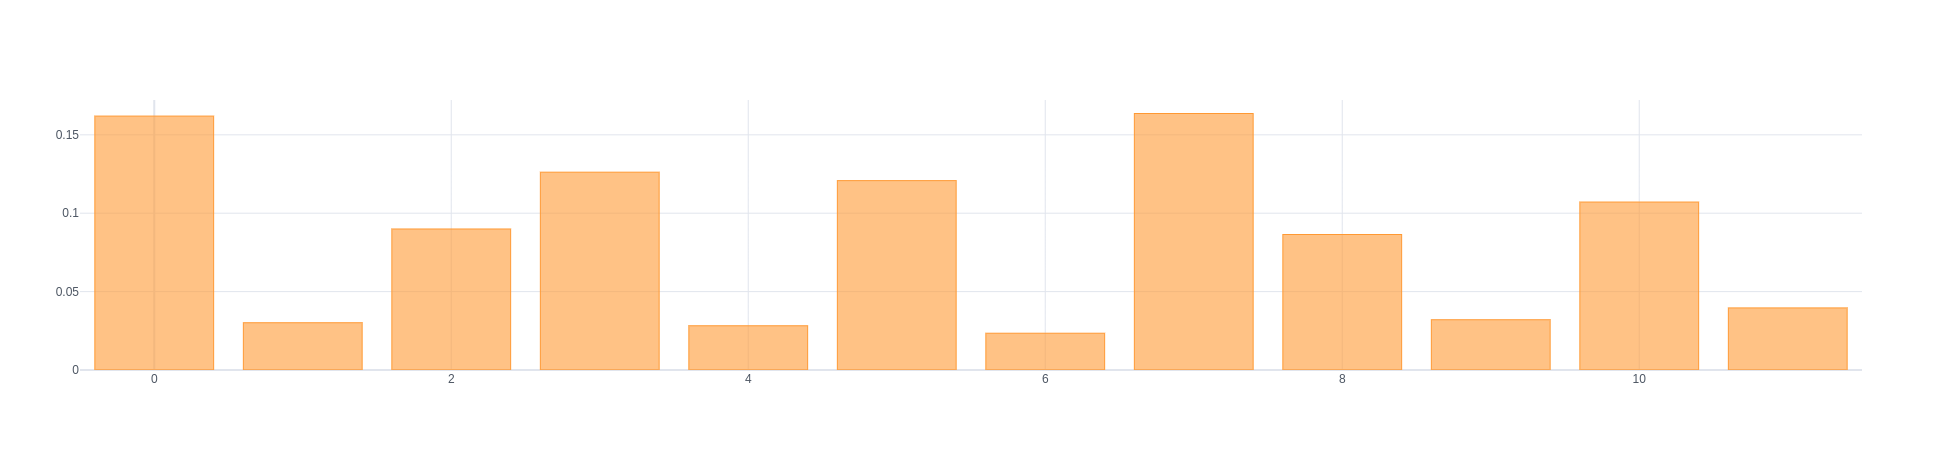

In [145]:
f.mean().iplot('bar')

### Rotate rows to start with maximum

In [ ]:
import numpy as np

rotate_to_max = lambda row: pd.Series(np.roll(row, -row.idxmax()))

In [ ]:
rolled_count = pc_counts.apply(rotate_to_max, axis=1)
rolled_count.T.iplot()

In [ ]:
rolled_dur = pc_durations.apply(rotate_to_max, axis=1)
rolled_dur.T.iplot()

In [ ]:
second_most = rolled_dur[range(1,12)].idxmax(axis=1)
second_most.value_counts()

In [ ]:
fourth_to_root = lambda row: pd.Series(np.roll(row, -5))

rolled_correct = rolled_dur.copy()
rolled_correct.loc[second_most == 5] = rolled_correct.loc[second_most == 5].apply(fourth_to_root, axis=1)
rolled_correct.T.iplot()

In [ ]:
mode = rolled_correct.apply(lambda r: 'minor' if r[3] > r[4] else 'major', axis=1)
mode.head(20)

### Ground truth keys

In [ ]:
keys['predicted'] = mode

In [ ]:
(keys['mode'] == keys.predicted).value_counts()

### With TPCs

In [ ]:
tpc_durations = notes.groupby(['id', 'tpc']).duration.sum().unstack().astype(float)
tpc_durations